In [1]:
from torchvision import transforms
from torchvision.utils import Image
import os
import torch.nn as nn
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import shutil
import cv2

2024-03-20 23:04:37.932450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 23:04:37.986435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 23:04:37.986457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 23:04:37.994617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 23:04:38.012510: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def Read_Data(is_train = True):
  temp = []
  temp2 = []
  updated_path = os.path.join("archive/VOC2012_train_val","VOC2012_train_val","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
  with open(updated_path,"r") as file_:
    Instances = file_.read().split()
    for img in Instances:
      path_img = os.path.join("archive/VOC2012_train_val","VOC2012_train_val","JPEGImages",img+".jpg")
      path_label = os.path.join("archive/VOC2012_train_val","VOC2012_train_val","SegmentationClass",img+".png")
      temp.append([path_img,path_label])
      path_img = os.path.join("dataset","images","validation",img+".jpg")
      path_label = os.path.join("dataset","masks","validation",img+".png")
      temp2.append([path_img,path_label])
  return temp, temp2

In [4]:
ls = os.listdir('dataset/images/train')
l = []
for i in ls:
    if i.endswith('Identifier'):
        l.append(i)
for w in l:
    os.remove(f'dataset/images/train/{w}')

In [5]:
import os
import cv2


input_dir = 'dataset/masks/validation'
output_dir = 'dataset/labels/validation'

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    # load the binary mask and get its contours
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)

    # print the polygons
    with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
        for polygon in polygons:
            for p_, p in enumerate(polygon):
                if p_ == len(polygon) - 1:
                    f.write('{}\n'.format(p))
                elif p_ == 0:
                    f.write('0 {} '.format(p))
                else:
                    f.write('{} '.format(p))

        f.close()

In [3]:
original, new_des = Read_Data(False)

In [4]:
for i in range(len(original)):
    shutil.move(original[i][1], new_des[i][1])

In [4]:
ms = []
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
for i in Train:
    mask = Image.open(i[1])
    mask_tensor = transform(mask)
    ms.append(mask_tensor)    

In [5]:
imgs = []
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
for i in Train:
    mask = Image.open(i[0])
    mask_tensor = transform(mask)
    imgs.append(mask_tensor)

In [6]:
data_set = []
for i in range(len(ms)):
    data_set.append([imgs[i],ms[i]])
print(len(data_set))

1464


In [7]:
dataset = DataLoader(data_set, batch_size=32, shuffle=True)

In [5]:
class UNetWithResNet(nn.Module):
    def __init__(self):
        super(UNetWithResNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(512,256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256,128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(128,64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.max(x1))
        x3 = self.enc3(self.max(x2))
        x4 = self.enc4(self.max(x3))

        x = self.upconv3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec1(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        # Define the last decoder block with skip connections
        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec3(x)
        return self.out(x)

In [9]:
model = UNetWithResNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in dataset:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 12.2537
Epoch [2/10], Loss: 7.7927
Epoch [3/10], Loss: 7.7980
Epoch [4/10], Loss: 7.8081
Epoch [5/10], Loss: 7.7514
Epoch [6/10], Loss: 7.7703
Epoch [7/10], Loss: 7.6762
Epoch [8/10], Loss: 7.5047
Epoch [9/10], Loss: 7.4118
Epoch [10/10], Loss: 7.5377


In [11]:
torch.save(model.state_dict(), 'f1_model.pt')

In [6]:
model = UNetWithResNet()
state_dic = torch.load('f1_model.pt')
model.load_state_dict(state_dic)

<All keys matched successfully>

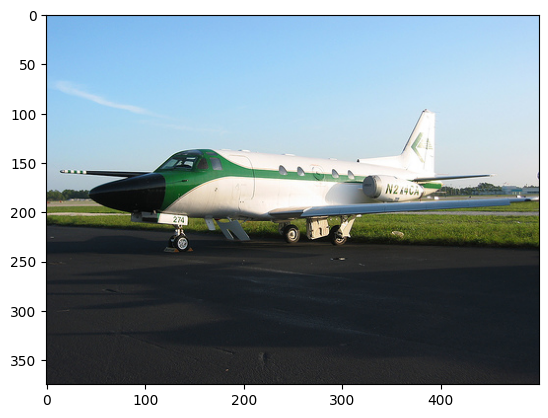

In [14]:
img = Image.open('VOC2012_test\\VOC2012_test\\JPEGImages\\2008_000012.jpg')
plt.imshow(img)
plt.show()

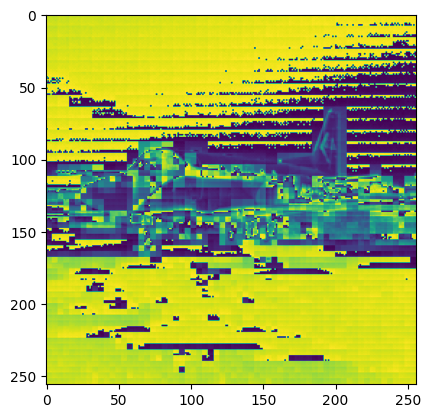

In [13]:
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
transformed_img = transform(img).unsqueeze(0)
prediction = model(transformed_img).squeeze(0)
retrans = transforms.Compose([transforms.ToPILImage()])
new_pred = retrans(prediction)
plt.imshow(new_pred)
plt.show()